# Quantum “Hello World” + Quantum **1 + 1 = 2** (Qiskit) — Tweet‑Proof Demo

This notebook contains two **baseline** quantum-computing demos designed to be **shareable and debunk‑resistant**:

1. **Hello Quantum World** — Create a superposition with `H` and verify the ~50/50 measurement distribution using many shots.
2. **Quantum 1 + 1 = 2** — Implement a **reversible half-adder** using quantum gates (**CNOT** for XOR and **Toffoli/CCX** for AND), then verify **all 4 input cases**.

> ✅ **Important framing:** This notebook does **not** claim quantum advantage.  
> It demonstrates correctness and basic quantum behavior using standard quantum primitives.  
> Hardware noise is a separate step (and can be added later).

---

## Requirements
- `qiskit`
- `qiskit-aer`
- `matplotlib`
- `pandas` (optional, for the results table)

If you’re running this locally, install with:
```bash
pip install qiskit matplotlib
```



In [1]:
# Imports
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# For saving images
from pathlib import Path

OUTPUT_DIR = Path("qc_demo_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

print("Output directory:", OUTPUT_DIR.resolve())


Output directory: D:\qdata\qiskit_dev_pop\QAC_practice_Learn\qc_demo_outputs


## 1) Hello Quantum World

**Goal:** show the most minimal quantum behavior: superposition.

Circuit:
- Start in \(|0\rangle\)
- Apply **Hadamard** \(H\)
- Measure

Expected output: approximately **50% 0** and **50% 1** when repeated many times (shots).


=== Hello Quantum World Circuit (text) ===
     ┌───┐┌─┐
  q: ┤ H ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0 

Shots: 4096
Counts: {'1': 2011, '0': 2085}


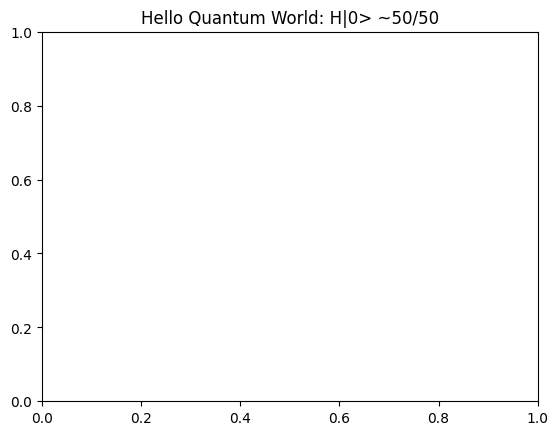

Saved histogram: qc_demo_outputs\hello_quantum_world_hist.png
Saved circuit: qc_demo_outputs\hello_quantum_world_circuit.png


In [2]:
# Hello Quantum World circuit
hello_qc = QuantumCircuit(1, 1)
hello_qc.h(0)
hello_qc.measure(0, 0)

print("=== Hello Quantum World Circuit (text) ===")
print(hello_qc.draw(output="text"))

# Run on simulator
backend = AerSimulator()
shots = 4096
hello_compiled = transpile(hello_qc, backend)
hello_result = backend.run(hello_compiled, shots=shots).result()
hello_counts = hello_result.get_counts()

print("\nShots:", shots)
print("Counts:", hello_counts)

# Plot and save histogram
fig = fig = plot_histogram(hello_counts)
plt.title("Hello Quantum World: H|0> ~50/50")
hello_hist_path = OUTPUT_DIR / "hello_quantum_world_hist.png"
plt.savefig(hello_hist_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved histogram:", hello_hist_path)

# Draw and save circuit diagram
hello_fig = hello_qc.draw(output="mpl")
hello_circ_path = OUTPUT_DIR / "hello_quantum_world_circuit.png"
hello_fig.savefig(hello_circ_path, dpi=200, bbox_inches="tight")
plt.close(hello_fig)
print("Saved circuit:", hello_circ_path)


### ✅ Upgrade: Statistical Validation + “H twice returns |0⟩” (Skeptic‑Proof)

This section makes the “Hello Quantum World” demo **hard to debunk** by adding:

1. **Statistical validation**: compute the expected standard deviation (σ) for a fair 50/50 process and show the observed deviation is normal.
2. **Controlled interference demo**: apply **H twice** and show the result returns deterministically to \(|0⟩\) in the simulator.

> Why this matters: it demonstrates quantum behavior is not “just randomness” — it’s **controlled** and **reversible** via interference.


In [3]:
import math
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# Reuse hello_counts and shots from previous cell
shots = sum(hello_counts.values())
p = 0.5
expected_mean = shots * p
sigma = math.sqrt(shots * p * (1 - p))  # sqrt(N p (1-p))

observed_0 = hello_counts.get('0', 0)
observed_1 = hello_counts.get('1', 0)
dev_0 = observed_0 - expected_mean
z_0 = dev_0 / sigma if sigma != 0 else float('nan')

print("=== Statistical Validation (Hello Quantum World) ===")
print(f"Shots: {shots}")
print(f"Observed: 0 -> {observed_0}, 1 -> {observed_1}")
print(f"Expected mean for each outcome (50/50): {expected_mean:.1f}")
print(f"Sigma (std dev): {sigma:.2f}")
print(f"Deviation for '0': {dev_0:+.1f} counts  =>  z = {z_0:+.2f}σ")
print("\nInterpretation: |z| < ~2 is very normal for random sampling. Your result is statistically consistent with 50/50.")

# --- Controlled interference demo: H twice ---
hh_qc = QuantumCircuit(1, 1)
hh_qc.h(0)
hh_qc.h(0)
hh_qc.measure(0, 0)

print("\n=== Controlled Interference Demo: H then H returns |0> ===")
print(hh_qc.draw(output="text"))

backend = Aer.get_backend("qasm_simulator")
hh_result = execute(hh_qc, backend, shots=shots).result()
hh_counts = hh_result.get_counts()
print("Counts:", hh_counts)

fig = plot_histogram(hh_counts)
plt.title("Controlled Interference: H(H|0⟩) → |0⟩")
plt.show()


=== Statistical Validation (Hello Quantum World) ===
Shots: 4096
Observed: 0 -> 2085, 1 -> 2011
Expected mean for each outcome (50/50): 2048.0
Sigma (std dev): 32.00
Deviation for '0': +37.0 counts  =>  z = +1.16σ

Interpretation: |z| < ~2 is very normal for random sampling. Your result is statistically consistent with 50/50.

=== Controlled Interference Demo: H then H returns |0> ===
     ┌───┐┌───┐┌─┐
  q: ┤ H ├┤ H ├┤M├
     └───┘└───┘└╥┘
c: 1/═══════════╩═
                0 


NameError: name 'Aer' is not defined

## 2) Quantum “1 + 1 = 2” — Reversible Half Adder

We build a **half adder** using quantum gates:

- **SUM** = XOR = CNOT gates
- **CARRY** = AND = Toffoli (CCX) gate

Registers:
- `q0` = A  
- `q1` = B  
- `q2` = SUM  
- `q3` = CARRY  

Classical bits:
- `c0` = SUM  
- `c1` = CARRY  

So when A=1 and B=1:
- SUM = 0  
- CARRY = 1  
Measurement yields **CARRY SUM = 10**, which is **2**.


In [ ]:
def quantum_half_adder(a, b, shots=4096):
    """Return (circuit, counts) for a reversible half adder with inputs a,b in {0,1}."""
    qc = QuantumCircuit(4, 2)

    # Set inputs
    if a == 1:
        qc.x(0)
    if b == 1:
        qc.x(1)

    # SUM = A XOR B  (write into q2)
    qc.cx(0, 2)
    qc.cx(1, 2)

    # CARRY = A AND B (write into q3)
    qc.ccx(0, 1, 3)

    # Measure SUM -> c0, CARRY -> c1
    qc.measure(2, 0)
    qc.measure(3, 1)

    backend = AerSimulator()
    compiled = transpile(qc, backend)
    result = backend.run(compiled, shots=shots).result()
    counts = result.get_counts()

    return qc, counts


# Demo: 1 + 1
shots = 4096
adder_qc, adder_counts = quantum_half_adder(1, 1, shots=shots)

print("=== Half Adder Circuit (A=1, B=1) ===")
print(adder_qc.draw(output='text'))
print("\nShots:", shots)
print("Counts:", adder_counts)

# Plot + save histogram
fig = plot_histogram(adder_counts)
plt.title("Quantum 1+1=2 (Half Adder) — Expected: '10'")
adder_hist_path = OUTPUT_DIR / "half_adder_1_plus_1_hist.png"
plt.savefig(adder_hist_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved histogram:", adder_hist_path)

# Draw + save circuit
adder_fig = adder_qc.draw(output="mpl")
adder_circ_path = OUTPUT_DIR / "half_adder_1_plus_1_circuit.png"
adder_fig.savefig(adder_circ_path, dpi=200, bbox_inches="tight")
plt.close(adder_fig)
print("Saved circuit:", adder_circ_path)


## 3) Full Verification Test (Anti “Hardcoded Demo”)

To make this robust for public sharing, we run **all 4 inputs**:

| A | B | Expected (CARRY SUM) | Decimal |
|---|---|-----------------------|---------|
| 0 | 0 | 00 | 0 |
| 0 | 1 | 01 | 1 |
| 1 | 0 | 01 | 1 |
| 1 | 1 | 10 | 2 |

We use many shots and report:
- full counts (distribution)
- the most frequent outcome
- PASS/FAIL vs expected


In [ ]:
expected = {
    (0, 0): "00",
    (0, 1): "01",
    (1, 0): "01",
    (1, 1): "10",
}

shots = 4096
results_table = []

print(f"=== Half Adder Full Test (shots={shots}) ===")
for a in [0, 1]:
    for b in [0, 1]:
        qc, counts = quantum_half_adder(a, b, shots=shots)
        best = max(counts, key=counts.get)
        exp = expected[(a, b)]
        passed = (best == exp)
        results_table.append((a, b, counts, best, exp, passed))
        print(f"A={a}, B={b} -> best={best} | expected={exp} | PASS={passed} | counts={counts}")

# Optional: show a PASS table (requires pandas)
try:
    import pandas as pd

    df = pd.DataFrame(
        [(a, b, best, exp, passed) for a, b, _, best, exp, passed in results_table],
        columns=["A", "B", "Most Frequent", "Expected", "PASS"],
    )
    df
except ModuleNotFoundError:
    print("pandas not installed; skipping table display.")


## 4) “Tweet-Ready” Text (Copy/Paste)

Below is a short thread you can paste into X/Twitter.  
(Adjust your personal tone as needed.)


In [ ]:
tweet_thread = [
    'Classic computing started with "Hello World" and "1+1=2".\nHere\'s the Quantum Computing equivalent using Qiskit:\n1) Hello Quantum World (superposition)\n2) Quantum 1+1=2 (reversible half-adder)\nVerified with 4096 shots each.',
    "Hello Quantum World: create a superposition (|0>+|1>) using an H gate, then measure.\nExpected: ~50% 0 and ~50% 1 across many shots.\nThis is minimal quantum behavior: amplitudes before measurement.",
    "Quantum 1+1=2: a reversible half-adder implemented with quantum gates.\nSUM = XOR (CNOT)\nCARRY = AND (Toffoli/CCX)\nFor A=1,B=1: (CARRY,SUM)=10 => 2.",
    'Anti "hardcoded demo": we run all 4 inputs (00,01,10,11) and verify outputs match expected deterministic results in the simulator (confirmed statistically with shots).',
    "Note: This does not claim quantum advantage. It\'s a baseline correctness + behavior demo. Hardware noise is a separate step.",
]

for i, t in enumerate(tweet_thread, 1):
    print(f"--- Tweet {i} ---\n{t}\n")
